# Kings County Housing Prices Bakeoff
## Project Intro

<br>

## Import Packages

In [1]:
import pandas as pd
import numpy as np
from statsmodels.formula.api import ols
# data visulization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
# stats
from scipy import stats
# sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics

<br>

## Import and Explore Dataset

In [134]:
# Read in CSV and drop unneeded columns
df = pd.read_csv('kc_house_data_train.csv')
df = df.drop(columns=['Unnamed: 0', 'id'])

df.shape

(17290, 20)

In [135]:
# View all columns
pd.set_option('display.max_columns', 100)

In [4]:
# look at first five rows
df.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,20141006T000000,365000.0,4,2.25,2070,8893,2.0,0,0,4,8,2070,0,1986,0,98058,47.4388,-122.162,2390,7700
1,20140821T000000,865000.0,5,3.00,2900,6730,1.0,0,0,5,8,1830,1070,1977,0,98115,47.6784,-122.285,2370,6283
2,20140815T000000,1038000.0,4,2.50,3770,10893,2.0,0,2,3,11,3770,0,1997,0,98006,47.5646,-122.129,3710,9685
3,20150331T000000,1490000.0,3,3.50,4560,14608,2.0,0,2,3,12,4560,0,1990,0,98034,47.6995,-122.228,4050,14226
4,20140714T000000,711000.0,3,2.50,2550,5376,2.0,0,0,3,9,2550,0,2004,0,98052,47.6647,-122.083,2250,4050


In [5]:
# look at columns and the datatypes
df.dtypes

date              object
price            float64
bedrooms           int64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront         int64
view               int64
condition          int64
grade              int64
sqft_above         int64
sqft_basement      int64
yr_built           int64
yr_renovated       int64
zipcode            int64
lat              float64
long             float64
sqft_living15      int64
sqft_lot15         int64
dtype: object

<br>

## Formating Date

In [6]:
# adding year, month, and day columns
df['date'] = df['date'].str.slice(0, 8, 1)
df['year_sold'] = df['date'].str.slice(0, 4, 1)
df['month_sold'] = df['date'].str.slice(4, 6, 1)
df['day_sold'] = df['date'].str.slice(6, 8, 1)

In [7]:
# Adjusting dtypes and dropping original data column
df['year_sold'] = df['year_sold'].astype('int64')
df['month_sold'] = df['month_sold'].astype('int64')
df['day_sold'] = df['day_sold'].astype('int64')
df = df.drop(columns='date')

<br>

## Create feature for rennovation

In [8]:
# replace 0 with yr_built so it doesnt think zero is a year -- last time the house was updated
df['yr_renovated'] = df['yr_renovated'].replace(0, df['yr_built'])

In [9]:
# get a bool value for rennovation
df['years_since_update'] = (2020 - df['yr_renovated'])

In the histogram matrix below, you can see the wide range of years since the house's last rennovation.

<br>

## Create feature for basement

In [10]:
# 0 == no basement, 1 == basement
df['basement'] = np.where(df['sqft_basement']==0, 0, 1)

<br>

## Looking at bedroom and bathrooms values

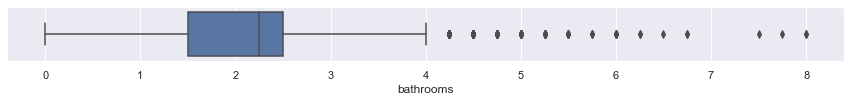

In [11]:
sns.set(rc={'figure.figsize':(15,1)});
sns.boxplot(data=df, x='bathrooms');

Because the bathroom outliers are evenly scattered, I made the decision to keep the outliers and the values that fall between 0 and 1. 

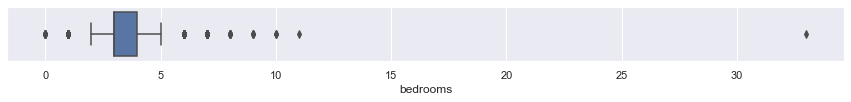

In [12]:
# check boxplot for outliers
sns.set(rc={'figure.figsize':(15,1)});
sns.boxplot(data=df, x='bedrooms');

In [13]:
# replacing 0 bedrooms with the median
df['bedrooms'] = df['bedrooms'].replace(0, df['bedrooms'].median())

### Statistical Test: Z-Score of house with 33 bedrooms

In [14]:
x_hat = df.bedrooms.max()
population_mean = df.bedrooms.mean()
population_std = df.bedrooms.std()

# execute z-score equation
z_score = (x_hat - population_mean) / population_std

print('Z-Score: ', z_score)

Z-Score:  31.678760980402068


This outlier falls 8.4 standard deviations outside the mean. The possibility of having that number of bedrooms in this dataset is almost zero. 

In [15]:
# updating incorrect value -- https://www.zillow.com/homedetails/8033-Corliss-Ave-N-Seattle-WA-98103/48795791_zpid/
df.at[8597,'bedrooms']= 3

<br>

## Plot the histograms for the current features

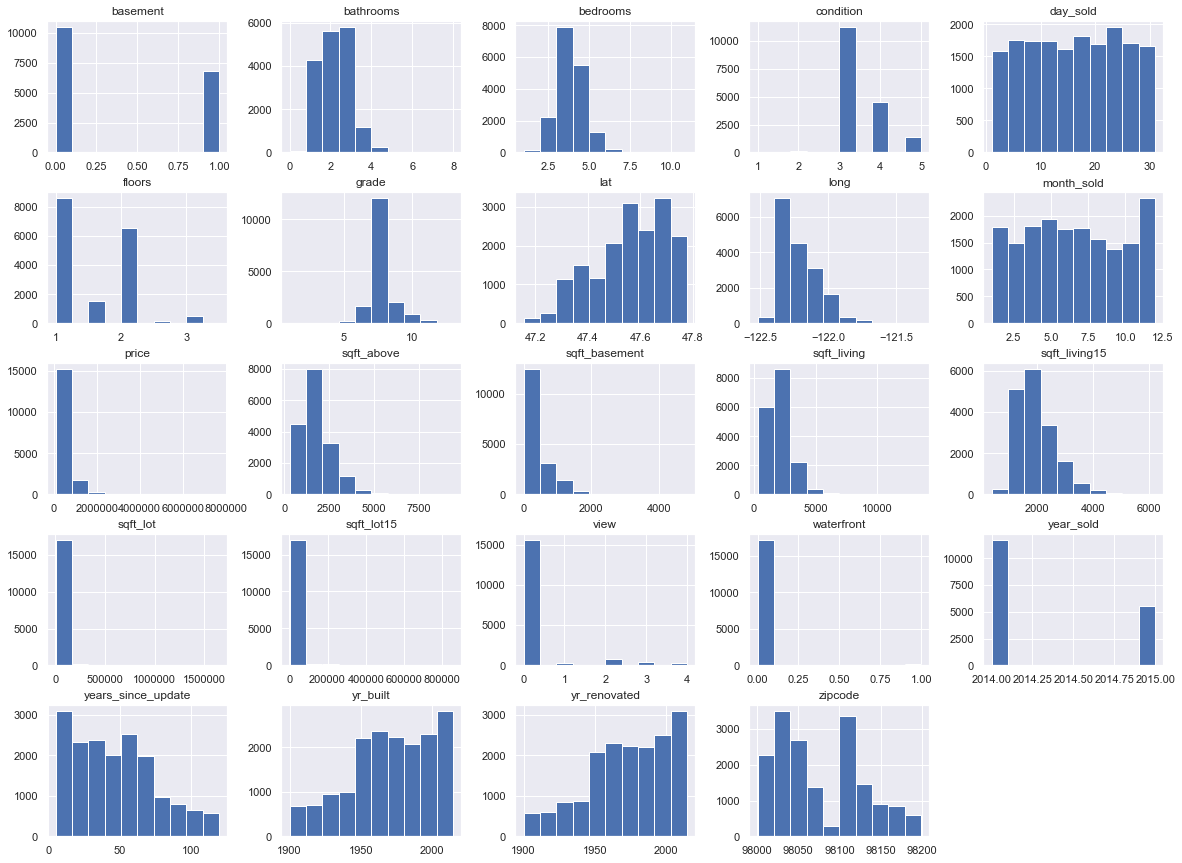

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
df.hist(bins=10, figsize=(20,15))
plt.show()

<br>

## Current Features Cross Tab

In [17]:
df.corr()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,year_sold,month_sold,day_sold,years_since_update,basement
price,1.000000,0.314587,0.524335,0.703540,0.086803,0.256985,0.275779,0.395485,0.036099,0.666215,0.607760,0.323312,0.056450,0.104812,-0.048958,0.302394,0.019327,0.585567,0.081423,-0.002334,-0.004350,-0.017157,-0.104812,0.176970
bedrooms,0.314587,1.000000,0.522885,0.590562,0.031391,0.183104,-0.008915,0.083395,0.019158,0.366205,0.490699,0.307814,0.162173,0.170880,-0.153810,-0.004494,0.131383,0.403313,0.029400,-0.010618,0.003622,-0.010916,-0.170880,0.162861
bathrooms,0.524335,0.522885,1.000000,0.755270,0.085470,0.497967,0.065848,0.188817,-0.122976,0.664191,0.686853,0.282700,0.507761,0.536815,-0.201527,0.023074,0.221308,0.568080,0.086499,-0.030045,0.012950,-0.000155,-0.536815,0.162507
sqft_living,0.703540,0.590562,0.755270,1.000000,0.166810,0.357169,0.109738,0.283336,-0.061530,0.762929,0.876696,0.435529,0.319397,0.342839,-0.195893,0.052646,0.234453,0.755066,0.179570,-0.033606,0.017737,-0.009618,-0.342839,0.203606
sqft_lot,0.086803,0.031391,0.085470,0.166810,1.000000,-0.002205,0.015356,0.073058,-0.013715,0.110320,0.180755,0.008065,0.054228,0.052918,-0.126590,-0.082029,0.226190,0.136959,0.701875,0.003141,-0.001722,0.004204,-0.052918,-0.038675
floors,0.256985,0.183104,0.497967,0.357169,-0.002205,1.000000,0.025132,0.025883,-0.259230,0.458984,0.528509,-0.247481,0.483657,0.498899,-0.060560,0.048227,0.128795,0.283933,-0.008170,-0.024641,0.019629,-0.000914,-0.498899,-0.260333
waterfront,0.275779,-0.008915,0.065848,0.109738,0.015356,0.025132,1.000000,0.407565,0.009608,0.092234,0.077162,0.083433,-0.021981,0.005262,0.034282,-0.013331,-0.042728,0.091090,0.026895,-0.000824,0.005685,0.012574,-0.005262,0.039484
view,0.395485,0.083395,0.188817,0.283336,0.073058,0.025883,0.407565,1.000000,0.045060,0.249554,0.164747,0.279939,-0.049593,-0.020531,0.089475,0.003820,-0.077572,0.279999,0.073185,0.000701,-0.004189,0.013054,0.020531,0.187475
condition,0.036099,0.019158,-0.122976,-0.061530,-0.013715,-0.259230,0.009608,0.045060,1.000000,-0.142066,-0.157466,0.166923,-0.358921,-0.392758,0.007068,-0.009927,-0.109200,-0.094307,-0.007125,-0.044871,0.017099,-0.006111,0.392758,0.131918
grade,0.666215,0.366205,0.664191,0.762929,0.110320,0.458984,0.092234,0.249554,-0.142066,1.000000,0.758247,0.165003,0.448003,0.458830,-0.184946,0.116196,0.198369,0.715745,0.116062,-0.036560,0.015166,-0.009128,-0.458830,0.048776


### The feature sqft_living has the highest correlation with price

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


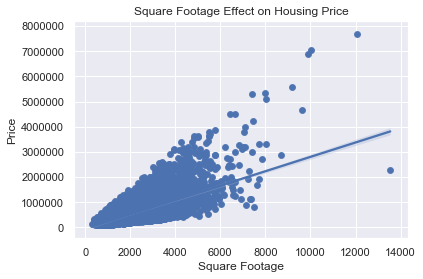

In [18]:
# create plot
df.plot.scatter(x='sqft_living', y='price');
sns.regplot(data=df, x='sqft_living', y='price');
plt.title('Square Footage Effect on Housing Price');
plt.xlabel('Square Footage');
plt.ylabel('Price');

### Breaking price down by month it was sold

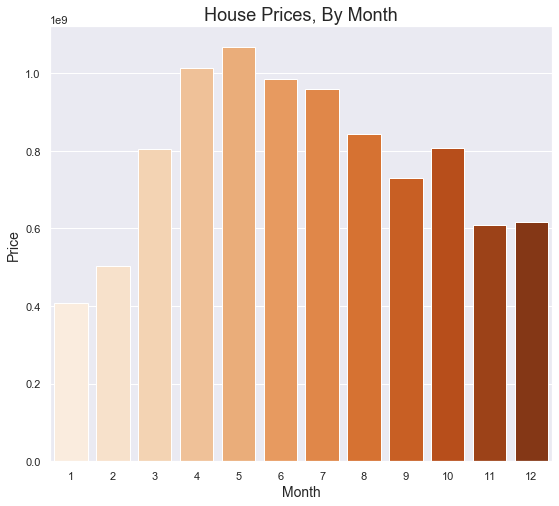

In [19]:
month_price = df.groupby(['month_sold'])['price'].sum().reset_index().sort_values('month_sold', ascending=True)

sns.set(rc={'figure.figsize':(9,8)})
plot = sns.barplot('month_sold','price' , data = month_price, order= month_price['month_sold'], palette='Oranges');
plot.set_title('House Prices, By Month',fontsize=18);
plt.xlabel('Month', fontsize=14);
plt.ylabel('Price', fontsize=14);

## Group Months into Quarters
In the bar visualization above, the highest three months are March, April, and May. Because those three compose quarter 2 of the year, I am creating 3 features for the first three quarters. Quarter 4 is the dummy variable.

In [20]:
df['q1'] = np.where((df['month_sold']==1) | (df['month_sold']==2) | (df['month_sold']==3), 1, 0)

In [21]:
df['q2'] = np.where((df['month_sold']==4) | (df['month_sold']==5) | (df['month_sold']==6), 1, 0)

In [22]:
df['q3'] = np.where((df['month_sold']==7) | (df['month_sold']==8) | (df['month_sold']==9), 1, 0)

<br>

## Statistical Test: Two Sample T-Test
- Our NULL hypothesis: mean of Q2 == mean of !Q2
- Our alternative hypothesis: mean of Q2 != mean of !Q2

In [23]:
# not Q2 == 0, Q2 == 1
df.groupby('q2')['price'].mean()

q2
0    532295.161033
1    558913.841386
Name: price, dtype: float64

In [24]:
pop_mean = df.price.mean()
pop_std = df.price.std()
print('POPULATION\nMean: ', pop_mean, '\nStandard Deviation:', pop_std)

q2_mean = df.groupby('q2')['price'].mean()[1]
q2_std = df.groupby('q2')['price'].std()[1]
q2_num = df.groupby('q2')['price'].count()[1]
print('\nQUARTER 2\nMean: ', q2_mean, '\nStandard Deviation:', q2_std)

not_q2_mean = df.groupby('q2')['price'].mean()[0]
not_q2_std = df.groupby('q2')['price'].std()[0]
not_q2_num = df.groupby('q2')['price'].count()[0]
print('\nQUARTER 1,3, AND 4\nMean: ', not_q2_mean, '\nStandard Deviation:', not_q2_std)

POPULATION
Mean:  540739.5486408329 
Standard Deviation: 373318.9787492793

QUARTER 2
Mean:  558913.8413855971 
Standard Deviation: 384954.0430415352

QUARTER 1,3, AND 4
Mean:  532295.1610334604 
Standard Deviation: 367498.58963784477


In [25]:
# Testing for the difference of two means

# laying out the equation
numerator = ((q2_mean - not_q2_mean) - 0)
denominator = (((q2_std**2)/q2_num)+((not_q2_std**2)/not_q2_num))**.5
# denominator = (((q2_std**2)/q2_num)+((not_q2_std**2)/not_q2_num))**.5

# calculating the t score
t = numerator/denominator

# calculate p-value from the t score
p_value = stats.t.sf(abs(t), df=(q2_num + not_q2_num - 2))

In [26]:
print('𝛼 = 0.05\nt-value: ', t, '\np-value: ', "%.15f" % p_value)

𝛼 = 0.05
t-value:  4.292344127490549 
p-value:  0.000008887944830


For this statistical test, the p-value is less than our alpha .05 meaning it is extremely unlikey to collect this sample data if the spending from both populations are equal to one another. Therefore, we can reject the null hypothesis.

<br>

## Distance from Top School Features
Code for scraper in scraper1.py

In [27]:
# import py file
import scraper1

# call function that scrapes school data
school_coordinates = scraper1.top_schools()
school_coordinates.head()

,name,lat,long,ad
0,Cascadia Elementary School,47.695213,-122.337156,"1700 N 90th Street Seattle, WA 98115"
1,Decatur Elementary School,47.685413,-122.283672,"7711 43rd Ave Ne Seattle, WA 98115"
2,Stella Schola,47.671574,-122.160037,"13505 Ne 75th Street Redmond, WA 98052"
3,Tesla Stem High School,47.645720,-122.035450,"4301 228th Ave Ne Redmond, WA 98053"
4,International Community School,47.664105,-122.191210,"11133 Ne 65th St Kirkland, WA 98033"


In [28]:
# house distance to a top school
from geopy.distance import geodesic

def get_distance(lat, long):
    miles = []
    for i in range(school_coordinates.shape[0]):
        school = (school_coordinates.loc[i]['lat'], school_coordinates.loc[i]['long'])
        miles.append(geodesic((lat,long), school).miles)
    return min(miles)

In [29]:
# this takes the longest time to run
for i in range(df.shape[0]):
    lat = df.loc[i]['lat']
    long = df.loc[i]['long']
    df.at[i, 'top_school_distance'] = get_distance(lat, long)
    

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


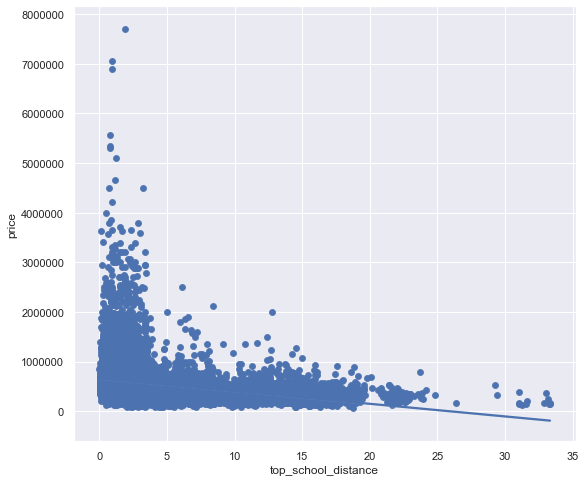

In [30]:
df.plot.scatter(x='top_school_distance', y='price');
sns.regplot(data=df, x='top_school_distance', y='price');

### Feature that indicates houses that are far from top schools (highest 25%)

In [31]:
df['far_school'] = np.where(df['top_school_distance'] > df['top_school_distance'].quantile(q=.75), 1, 0)

<br>

In [32]:
## Polynomial Features

<br>

## Model 1: Multiple Linear Regression

In [34]:
model = ols(formula='price~bedrooms+bathrooms+lat+basement+top_school_distance+sqft_living+grade+waterfront+view+yr_built+yr_renovated+sqft_living15', data=df)

In [35]:
X = df[['bedrooms', 'bathrooms', 'lat', 'sqft_living', 'basement', 'top_school_distance', 'grade', 'waterfront', 'view', 'yr_built', 'yr_renovated', 'sqft_living15']] #predictors as x
y = df['price'] # target as y

X_train, X_test, y_train, y_test = train_test_split(X, y,               # Pass in our X and y
                                                    random_state=42,    # Abritary select a random_state 
                                                    test_size=.2        # Split test size to be 20% of full data.
                                                   )

# Instantiate MinMaxScaler object
# lots of different ways to scale our data
minmax = MinMaxScaler()

# # Fit and Transform the training data.
X_train_transformed = minmax.fit_transform(X_train)

# # ONLY TRANSFORM the test data.
# #------- NEVER fit
X_test_transformed = minmax.transform(X_test)

# # Instantiate the Linear Regression Object.
model = LinearRegression()

# # Fit the model to the transformed X_train, and the y_train.
model.fit(X_train_transformed, y_train)

# # Score the model based on the transformed X_test and the y_test.
model.score(X_test_transformed, y_test)

0.7036204645681844

In [37]:
y_train_pred = model.predict(X_train)

In [38]:
train_rmse = np.sqrt(metrics.mean_squared_error(y_train, y_train_pred))


In [39]:
train_rmse

5101806668.247169

In [40]:
y_test_pred = model.predict(X_test)

In [41]:
test_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_test_pred))

In [42]:
print('Training Root Mean Squared Error:' , train_rmse, '\nTesting Root Mean Squared Error:' , test_rmse)

Training Root Mean Squared Error: 5101806668.247169 
Testing Root Mean Squared Error: 4981710090.952595


## Train-Test Split
If you plan on doing any scaling of your data, make sure it is done at the appropriate time.

In [43]:
# df.drop(['date_sold'], axis=1, inplace=True)

In [44]:
# # not using this because VIF is too high
# df.drop('yr_renovated', axis=1, inplace = True)

In [45]:
df_features = list(df.columns)
df_features.remove('price')
df_features = df[df_features]
target = df['price']

In [46]:
# STRATIFY YOUR SPLIT - sqft_living has the highest correlation break into quartiles

# X = df[['bedrooms', 'bathrooms', 'lat', 'sqft_living', 'basement', 'top_school_distance', 'grade', 'waterfront', 'view', 'yr_built', 'yr_renovated', 'sqft_living15']] #predictors as x
# y = df['price'] # target as y

# Abritary select a random_state and split test size to be 20% of full data.
X_train, X_test, y_train, y_test = train_test_split(df_features, target, 
                                                    random_state=33,    # Abritary select a random_state 
                                                    test_size=0.2        # Split test size to be 20% of full data.
                                                   )


<br>

## Scale Train and Test Set

In [47]:
scaler = StandardScaler()

# fit the scaler to the training data
scaler.fit(X_train)

#transform the training data
X_train = pd.DataFrame(data=scaler.transform(X_train), columns=df_features.columns)

#transform the testing dat
X_test = pd.DataFrame(data=scaler.transform(X_test), columns=df_features.columns)

<br>

## Model 2: Predicting the Log of Price

In [62]:
#take the natural log of the target variable
y_log = np.log(y_train)

In [63]:
#instantiate a linear regression object
lm_log = LinearRegression()

#fit the linear regression to the data
lm_log = lm_log.fit(X_train, y_log)

log_train_pred = lm_log.predict(X_train)

In [64]:
#log_train_pred the predictions to get them on the same original scale 
y_train_pred = np.exp(log_train_pred)

In [65]:
log_train_rmse = np.sqrt(metrics.mean_squared_error(y_train, log_train_pred))

In [66]:
log_test_pred = lm_log.predict(X_test)
#exponentiate the predictions to get them on the same original scale 
log_test_pred = np.exp(log_test_pred)
log_test_rmse = np.sqrt(metrics.mean_squared_error(y_test, log_test_pred))


print('Training Root Mean Squared Error:' , log_train_rmse, '\nTesting Root Mean Squared Error:' , log_test_rmse)

Training Root Mean Squared Error: 656635.3048448806 
Testing Root Mean Squared Error: 197196.9553208331


<br>

## Model 3: F-Test Feature Selection

In [67]:
X_train.shape

(13832, 28)

In [68]:
from sklearn.feature_selection import SelectKBest, f_regression,mutual_info_regression

selector = SelectKBest(f_regression, k=22)

selector.fit(X_train, y_train)

SelectKBest(k=22, score_func=<function f_regression at 0x7fdc46a43048>)

In [69]:
selected_columns = X_train.columns[selector.get_support()]
removed_columns = X_train.columns[~selector.get_support()]

In [70]:
list(selected_columns)

['bedrooms',
 'bathrooms',
 'sqft_living',
 'sqft_lot',
 'floors',
 'waterfront',
 'view',
 'condition',
 'grade',
 'sqft_above',
 'sqft_basement',
 'yr_built',
 'yr_renovated',
 'zipcode',
 'lat',
 'sqft_living15',
 'sqft_lot15',
 'years_since_update',
 'basement',
 'q2',
 'top_school_distance',
 'far_school']

In [57]:
from sklearn import linear_model
from sklearn.feature_selection import RFECV

In [58]:
ols = linear_model.LinearRegression()

In [59]:
# Create recursive feature eliminator that scores features by mean squared errors
selector = RFECV(estimator=ols, step=1, cv=5, scoring='neg_mean_squared_error', n_jobs=-1) # running on different cores

# Fit recursive feature eliminator 
selector.fit(X_train, y_train)

RFECV(cv=5,
      estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                 normalize=False),
      min_features_to_select=1, n_jobs=-1, scoring='neg_mean_squared_error',
      step=1, verbose=0)

In [60]:
selected_rfe = X_train.columns[selector.support_]
removed_rfe = X_train.columns[~selector.support_]

In [61]:
#instantiate a linear regression object
lm_rfe = LinearRegression()

#fit the linear regression to the data
lm_rfe = lm_rfe.fit(X_train[selected_rfe], y_train)

y_rfe = lm_rfe.predict(X_train[selected_rfe])


trainRFE_rmse = np.sqrt(metrics.mean_squared_error(y_train, y_rfe))


print('Training Root Mean Squared Error:' , trainRFE_rmse)

y_pred_rfe = lm_rfe.predict(X_test[selected_rfe])

testRFE_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred_rfe))

print('Testing Root Mean Squared Error:' , testRFE_rmse)


Training Root Mean Squared Error: 199384.74023705925
Testing Root Mean Squared Error: 209499.3396287882


<br>

## Comparing the models

In [75]:
print('RMSE')
print('MLR:', train_rmse)
print('LOG:', log_test_rmse)
print('F-TEST:', testRFE_rmse)

RMSE
MLR: 656635.3048448806
LOG: 197196.9553208331
F-TEST: 209499.3396287882


<br>

## Final Model

In [112]:
df.shape

(17290, 29)

In [98]:
df_features

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,year_sold,month_sold,day_sold,years_since_update,basement,q1,q2,q3,top_school_distance,far_school
0,4,2.25,2070,8893,2.0,0,0,4,8,2070,0,1986,1986,98058,47.4388,-122.162,2390,7700,2014,10,6,34,0,0,0,0,7.169534,1
1,5,3.00,2900,6730,1.0,0,0,5,8,1830,1070,1977,1977,98115,47.6784,-122.285,2370,6283,2014,8,21,43,1,0,0,1,0.488451,0
2,4,2.50,3770,10893,2.0,0,2,3,11,3770,0,1997,1997,98006,47.5646,-122.129,3710,9685,2014,8,15,23,0,0,0,1,1.069469,0
3,3,3.50,4560,14608,2.0,0,2,3,12,4560,0,1990,1990,98034,47.6995,-122.228,4050,14226,2015,3,31,30,0,1,0,0,1.168206,0
4,3,2.50,2550,5376,2.0,0,0,3,9,2550,0,2004,2004,98052,47.6647,-122.083,2250,4050,2014,7,14,16,0,0,0,1,0.980389,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17285,5,2.50,3240,9960,1.0,0,1,3,8,2020,1220,1958,1958,98008,47.5858,-122.112,2730,10400,2015,3,3,62,1,1,0,0,0.469082,0
17286,2,1.75,1300,4000,2.0,0,0,3,7,1300,0,1948,1948,98105,47.6687,-122.288,1350,4013,2014,5,20,72,0,0,1,0,1.172172,0
17287,3,1.00,1050,9876,1.0,0,0,3,7,1050,0,1953,1953,98028,47.7635,-122.262,1760,9403,2014,5,14,67,0,0,1,0,3.571476,0
17288,3,1.50,1900,43186,1.5,0,0,4,7,1300,600,1971,1971,98038,47.4199,-121.990,2080,108028,2014,12,4,49,1,0,0,0,7.313081,1


In [146]:
final_df.shape

(17290, 28)

In [113]:
final_df = df.drop('price', axis=1)

In [114]:
final_df.shape

(17290, 28)

In [102]:
scaler = StandardScaler()

#fit and transform the  data
final_df = pd.DataFrame(data=scaler.fit_transform(final_df), columns=final_df.columns)

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/extmath.py:747: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/extmath.py:688: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = op(x, *args, **kwargs)


In [103]:
selector = SelectKBest(f_regression, k=22)

In [107]:
target = pd.DataFrame(target)

In [115]:
selector.fit(final_df, target)

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SelectKBest(k=22, score_func=<function f_regression at 0x7fdc46a43048>)

In [81]:
final_df.shape

(17290, 29)

In [82]:
X_train.shape

(13832, 28)

In [148]:
list(selected_columns)

['bedrooms',
 'bathrooms',
 'sqft_living',
 'sqft_lot',
 'floors',
 'waterfront',
 'view',
 'condition',
 'grade',
 'sqft_above',
 'sqft_basement',
 'yr_built',
 'yr_renovated',
 'zipcode',
 'lat',
 'sqft_living15',
 'sqft_lot15',
 'years_since_update',
 'basement',
 'q2',
 'top_school_distance',
 'far_school']

In [116]:
selected_columns = X_train.columns[selector.get_support()]
removed_columns = X_train.columns[~selector.get_support()]

In [143]:
#instantiate a linear regression object
model_final = LinearRegression()

#fit the linear regression to the data
model_final = model_final.fit(final_df[selected_columns], target)

In [144]:
model_final

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [130]:
coef = []
for x in model_final.coef_:
    for item in x:
        coef.append(item)

In [131]:
list(zip(df_features, coef))

[('bedrooms', -39656.667167953376),
 ('bathrooms', 42631.2254898001),
 ('sqft_living', 117.0709370136205),
 ('sqft_lot', 0.10014031040753958),
 ('floors', 5192.574991956655),
 ('waterfront', 597922.0664465118),
 ('view', 55032.392658211065),
 ('condition', 26053.276867151002),
 ('grade', 95765.20085059488),
 ('sqft_above', 69.23496497336643),
 ('sqft_basement', 47.835972073689014),
 ('yr_built', -3223.076750444723),
 ('yr_renovated', 248.9168489983684),
 ('zipcode', -418.8805276201869),
 ('lat', 232040.22869887366),
 ('long', 8.427553625177858),
 ('sqft_living15', -0.3157722378484221),
 ('sqft_lot15', -248.91684897496023),
 ('year_sold', -7231.290514267639),
 ('month_sold', 11857.05069128524),
 ('day_sold', -10063.115068254674),
 ('years_since_update', -36570.89129933744)]

## Saving final model using pickle.
https://machinelearningmastery.com/save-load-machine-learning-models-python-scikit-learn/

In [132]:
import pickle

pickle_out = open("model.pickle","wb")
pickle.dump(model_final, pickle_out)
pickle_out.close()

In [133]:
pickle_out = open('scaler.pickle', 'wb')
pickle.dump(scaler, pickle_out)
pickle_out.close()

In [140]:
import joblib

In [142]:
joblib_file = "model1.pkl"  
joblib.dump(model_final, joblib_file)

['model1.pkl']

In [145]:
joblib_file = "scaler1.pkl"  
joblib.dump(scaler, joblib_file)

['scaler1.pkl']